In [26]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp
from numba.typed import List

from collections import namedtuple

np.set_printoptions(linewidth=160, precision=2)

In [27]:
ParamTuple = namedtuple("ParamTuple", ["gamma", "p"])

In [28]:
# @jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [29]:
@jit(nopython=True)
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states = len(policy)

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, -1, -1))  # Append the absorbing state
            break
        chosen_action = policy[current_state]
        # Manually sample next_state based on T_true
        cumulative_prob = 0.0
        rand_num = np.random.rand()
        next_state = 0
        for s in range(n_states):
            cumulative_prob += T_true[current_state, chosen_action, s]
            if rand_num < cumulative_prob:
                next_state = s
                break

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state

    trajectory = np.array(trajectory)
    return trajectory

In [30]:
@jit(nopython=True)
def generate_n_trajectories(
    T_true, policy, absorbing_states, n_trajectories=100, max_steps=100
):
    trajectories = List()
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(T_true, policy, absorbing_states, max_steps=max_steps)
        )
    return trajectories

In [31]:
# @jit(nopython=True)
def make_absorbing(R: np.ndarray, T: np.ndarray) -> None:
    reward_indices = np.where(R > 0)[0]
    T[reward_indices, :, :] = 0
    T[reward_indices, :, reward_indices] = 1

In [32]:
@jit(nopython=True)
def transition_matrix(N, M, p):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    return T

In [33]:
def plot_trajectories(N, M, trajectories, reward_matrix):
    plt.figure(figsize=(M, N))

    # Plot rewards as heatmap
    plt.imshow(reward_matrix.reshape(N, M), cmap="viridis", origin="upper")

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        plt.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    plt.colorbar(label="Reward")
    plt.gca().xaxis.tick_top()
    plt.show()

In [34]:
def plot_value_and_policy(
    value_function, policy, grid_shape, absorbing_states, title="", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=grid_shape[::-1])

    ax.imshow(
        value_function.reshape(grid_shape),
        cmap="viridis",
        origin="upper",
        interpolation="nearest",
    )
    # Make colorbar
    cbar = ax.figure.colorbar(ax.get_images()[0])

    for s, val in enumerate(value_function):
        if s in absorbing_states:
            continue  # Skip arrows for absorbing states

        row, col = divmod(s, grid_shape[1])
        action = policy[s]
        if action == 0:  # N
            dx, dy = 0, -0.4
        elif action == 1:  # E
            dx, dy = 0.4, 0
        elif action == 2:  # S
            dx, dy = 0, 0.4
        elif action == 3:  # W
            dx, dy = -0.4, 0
        # make arrow
        ax.arrow(col, row, dx, dy, head_width=0.1, head_length=0.1, fc="r", ec="r")

    ax.set_title(title)

In [35]:
# Make function that counts state visit frequencies from trajectories
@jit(nopython=True)
def count_state_visits(trajectories, n_states):
    state_visits = np.zeros(n_states)
    for traj in trajectories:
        for s, _, _ in traj:
            state_visits[s] += 1
    return state_visits / state_visits.sum()

### Define a world where different $\gamma$ leads to different optimal policies


In [36]:
# World definition

# Key: S: start, Number: Reward size

# Idea is that the agent goes right and at every step decides whether to
# take the immediate reward or go for a bigger reward

#   0 1 2 3 4 5
# 0 S . . . . .
# 1 1 2 3 4 5 6

In [37]:
N, M = 2, 6  # dimensions of the gridworld

n_states, n_actions = N * M, 4
R = np.array(
    [
        [0] * 6,
        range(1, 7),
    ]
).flatten()

# p_agent_ground = 0.5  # Agent's transition probability that we're interested in learning
# gamma_agent_ground = 0.5  # Agent's discount factor that we're interested in learning

true_params = ParamTuple(gamma=0.5, p=0.5)

T_agent_ground = transition_matrix(N, M, p=true_params.p)  # Agent's transition matrix
T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
absorbing_states = np.where(R > 0)[0]  # Absorbing states

make_absorbing(R, T_agent_ground)
make_absorbing(R, T_true)

In [38]:
# Generate V and policy
V_ground, ground_policy = value_iteration_with_policy(
    R, T_agent_ground, gamma=true_params.gamma
)
non_absorbing_states = np.where(R <= 0)[0]
ground_policy[non_absorbing_states]

array([2, 2, 2, 2, 2, 2], dtype=int32)

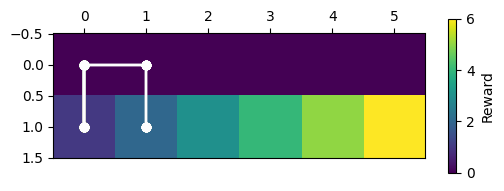

In [39]:
# Generate trajectories
trajectories = generate_n_trajectories(
    T_true, ground_policy, absorbing_states, n_trajectories=1000, max_steps=100
)

plot_trajectories(N, M, trajectories, R)

array([[0.37, 0.67, 1.  , 1.33, 1.66, 1.97],
       [1.  , 2.  , 3.  , 4.  , 5.  , 6.  ]])

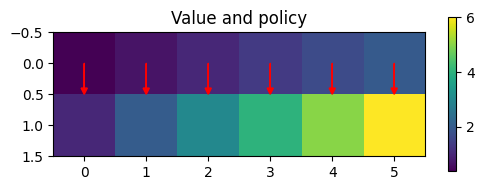

In [40]:
plot_value_and_policy(
    V_ground, ground_policy, (N, M), absorbing_states, title="Value and policy"
)
V_ground.reshape((N, M))

In [41]:
len(trajectories)

1000

In [42]:
empirical_freq_agent = count_state_visits(trajectories, n_states)

with np.printoptions(formatter={"all": "{:.2f}%".format}):
    print(empirical_freq_agent.reshape((N, M)) * 100)

[[51.28% 1.23% 0.00% 0.00% 0.00% 0.00%]
 [46.30% 1.19% 0.00% 0.00% 0.00% 0.00%]]


In [43]:
# @jit(nopython=True)
def calculate_errors(
    N,
    M,
    R,
    ground_policy,
):
    # Step 1: Generate parameter grid
    gamma_values = np.linspace(0.01, 0.99, num=20)
    p_values = np.linspace(0.01, 0.99, num=20)

    # Initialize array to store MSE values
    policy_matches = np.zeros((len(gamma_values), len(p_values)))

    # Loop through each pair of parameters
    pbar = tqdm(total=len(gamma_values) * len(p_values))
    for i, gamma in enumerate(gamma_values):
        for j, p in enumerate(p_values):
            pbar.update(1)
            pbar.set_description(f"gamma={gamma:.2f}, p={p:.2f}")
            # Step 2: Create T_agent using p and make it absorbing
            T_agent = transition_matrix(N, M, p=p)
            make_absorbing(R, T_agent)

            # Step 3: Solve environment to get value function and policy
            V, policy = value_iteration_with_policy(R, T_agent, gamma=gamma)

            # Step 4: Calculate proportion of states where the policy matches the ground truth
            # but only for non-absorbing states
            policy_match = np.mean(
                policy[non_absorbing_states] == ground_policy[non_absorbing_states]
            )

            # Store the policy match value
            policy_matches[i, j] = policy_match

    return gamma_values, p_values, policy_matches.flatten()

In [44]:
def get_param_estimate(best_params) -> ParamTuple:
    # Calculate the mean of best gamma and p values
    mean_best_gamma = np.mean([gamma for gamma, _ in best_params])
    mean_best_p = np.mean([p for _, p in best_params])

    # Return the mean values as a ParamTuple
    return ParamTuple(gamma=mean_best_gamma, p=mean_best_p)

In [45]:
def find_best_params(N, M, R, ground_policy):
    gamma_values, p_values, policy_matches = calculate_errors(N, M, R, ground_policy)

    param_grid = list(product(gamma_values, p_values))

    # Step 6: Find parameters that minimize MSE
    max_match = np.max(policy_matches)

    # Get indices of all minimum MSE values
    max_mse_indices = np.where(policy_matches == max_match)[0]

    # Extract corresponding gamma and p values
    best_params = [param_grid[idx] for idx in max_mse_indices]
    est_params = get_param_estimate(best_params)

    return est_params, (gamma_values, p_values, policy_matches)

In [46]:
def plot_param_estimate(
    gamma_values,
    p_values,
    policy_matches,
    true_params: ParamTuple,
    est_params: ParamTuple,
    title=None,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(
        policy_matches.reshape((len(gamma_values), len(p_values))),
        interpolation="nearest",
        cmap="coolwarm",
        origin="lower",
        extent=[0, 1, 0, 1],
    )
    # plt.colorbar(label="Percentage equal")
    # Set the colorbar with label "Percentage equal" and format as percentage
    cbar = ax.figure.colorbar(
        ax.get_images()[0], ax=ax, format=lambda x, pos: f"{x:.0%}"
    )
    cbar.ax.set_ylabel("Percentage equal")

    ax.set_xlabel("p")
    ax.set_ylabel("gamma")

    if title is None:
        title = "MSE across different values of gamma and p"

    ax.set_title(title)

    # Mark the true gamma and p values, and the best gamma and p values
    ax.scatter(true_params.p, true_params.gamma, marker="*", s=200, c="k", label="True")
    ax.scatter(
        est_params.p, est_params.gamma, marker="*", s=200, c="r", label="Estimated best"
    )

    ax.grid(True)

    ax.legend(frameon=False)

gamma=0.01, p=0.89:   4%|▍         | 18/400 [00:00<00:00, 1228.30it/s]

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:03<00:00, 114.67it/s]


Mean Best gamma: 0.30776386913229026, Mean Best p: 0.6002304409672832


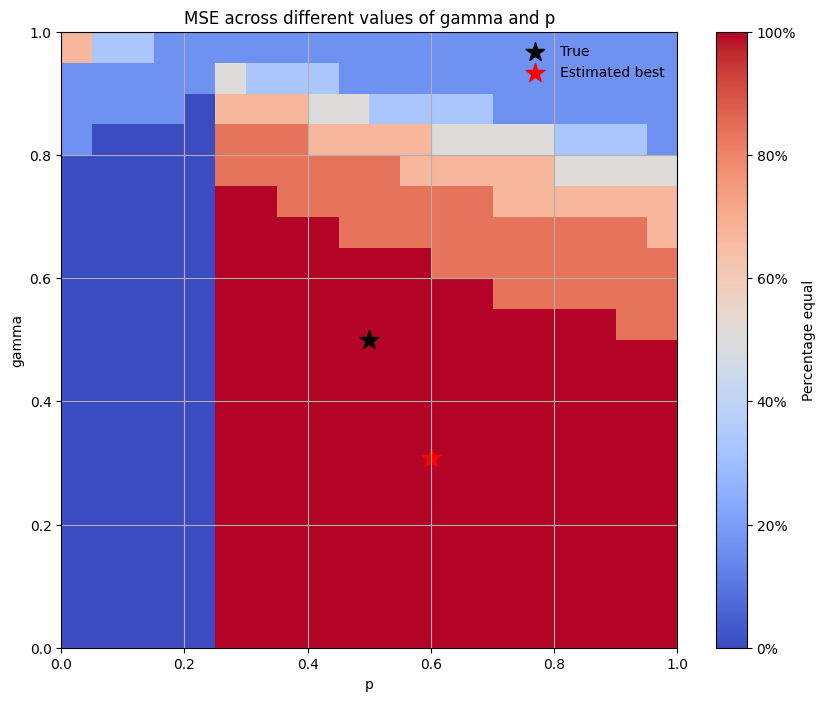

In [47]:
# Run the function
(
    est_params,
    (gamma_values, p_values, policy_matches),
) = find_best_params(N, M, R, ground_policy)

print(f"Mean Best gamma: {est_params.gamma}, Mean Best p: {est_params.p}")

plot_param_estimate(
    gamma_values,
    p_values,
    policy_matches,
    true_params=true_params,
    est_params=est_params,
)

## What happens when we design random worlds and observe the same agent?


In [48]:
def generate_random_world(seed=None):
    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Randomly generate dimensions between 4 and 12 for height and width
    N, M = np.random.randint(4, 13, size=2)

    # Initialize reward matrix with zeros and a few sparse positive rewards
    n_states = N * M
    R = np.zeros((N, M))
    num_positive_rewards = np.random.randint(
        1, int(0.1 * n_states) + 1
    )  # 10% of states as upper limit
    pos_reward_positions = np.random.choice(
        n_states, num_positive_rewards, replace=False
    )
    for pos in pos_reward_positions:
        i, j = divmod(pos, M)
        R[i, j] = np.random.randint(1, 11)  # Random positive reward between 1 and 10

    # Add some negative rewards
    num_negative_rewards = np.random.randint(1, int(0.1 * n_states) + 1)
    neg_reward_positions = np.random.choice(
        n_states, num_negative_rewards, replace=False
    )
    for pos in neg_reward_positions:
        i, j = divmod(pos, M)
        R[i, j] = -np.random.randint(1, 11)  # Random negative reward between -1 and -10

    # Create transition matrices
    T_true = transition_matrix(N, M, p=np.random.uniform(0.5, 1))

    # Define absorbing states
    R = R.flatten()
    absorbing_states = np.where(R > 0)[0]

    # Make states absorbing
    make_absorbing(R, T_true)

    return (
        N,
        M,
        R,
        T_true,
        absorbing_states,
    )

In [49]:
def plot_gridworld(R, dimensions, title="Gridworld", ax=None):
    if not ax:
        fig, ax = plt.subplots()
    cmap = plt.colormaps["coolwarm"]
    R = R.reshape(dimensions)
    ax.matshow(R, cmap=cmap)

    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            ax.text(j, i, str(int(R[i, j])), ha="center", va="center", fontsize=12)

    ax.set_title(title)
    ax.axis("off")

Dimensions: 9 x 4


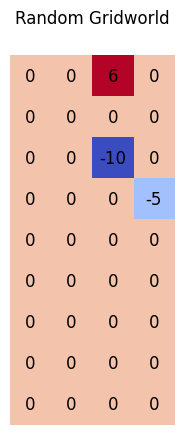

In [50]:
# You can now call this function to generate a random world
(
    N1,
    M1,
    R1,
    T_true1,
    absorbing_states1,
) = generate_random_world()


print(f"Dimensions: {N1} x {M1}")

plot_gridworld(R1, (N1, M1), "Random Gridworld")

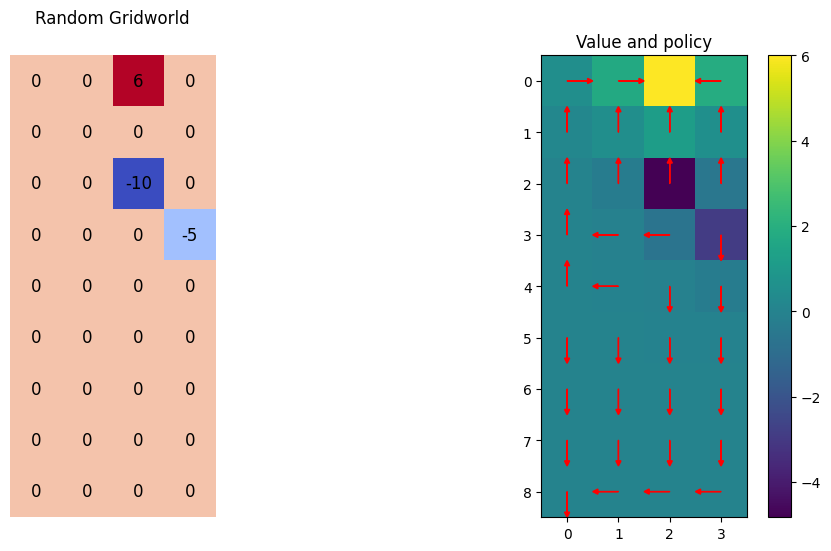

In [51]:
# Make the agent's transition matrix
T_agent1 = transition_matrix(N1, M1, p=true_params.p)
make_absorbing(R1, T_agent1)

# Generate V and policy
V_ground1, ground_policy1 = value_iteration_with_policy(
    R1, T_agent1, gamma=true_params.gamma
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_gridworld(R1, (N1, M1), "Random Gridworld", ax=ax1)

plot_value_and_policy(
    V_ground1,
    ground_policy1,
    (N1, M1),
    absorbing_states1,
    title="Value and policy",
    ax=ax2,
)

In [52]:
def solve_random_world(true_params: ParamTuple, seed=None):
    # Generate random world
    (
        N,
        M,
        R,
        T_true,
        absorbing_states,
    ) = generate_random_world(seed=seed)

    # Make the agent's transition matrix based on the new world
    T_agent = transition_matrix(N, M, p=true_params.p)
    make_absorbing(R, T_agent)

    # Generate V and policy
    V_ground, ground_policy = value_iteration_with_policy(
        R, T_agent, gamma=true_params.gamma
    )

    # Based on the current policy in the new world, find what params match the policy
    (
        est_params,
        (gamma_values, p_values, policy_matches),
    ) = find_best_params(N, M, R, ground_policy)

    print(f"Mean Best gamma: {est_params.gamma}, Mean Best p: {est_params.p}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the random world
    plot_gridworld(R, (N, M), "Random Gridworld", ax=ax1)

    # Plot the value function and policy
    plot_value_and_policy(
        V_ground,
        ground_policy,
        (N, M),
        absorbing_states,
        title="Value and policy",
        ax=ax2,
    )

    plot_param_estimate(
        gamma_values,
        p_values,
        policy_matches,
        true_params=true_params,
        est_params=est_params,
        ax=ax3,
    )
    plt.show()

    return policy_matches

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:24<00:00, 16.19it/s] 


Mean Best gamma: 0.48989993996397835, Mean Best p: 0.6148268961376827


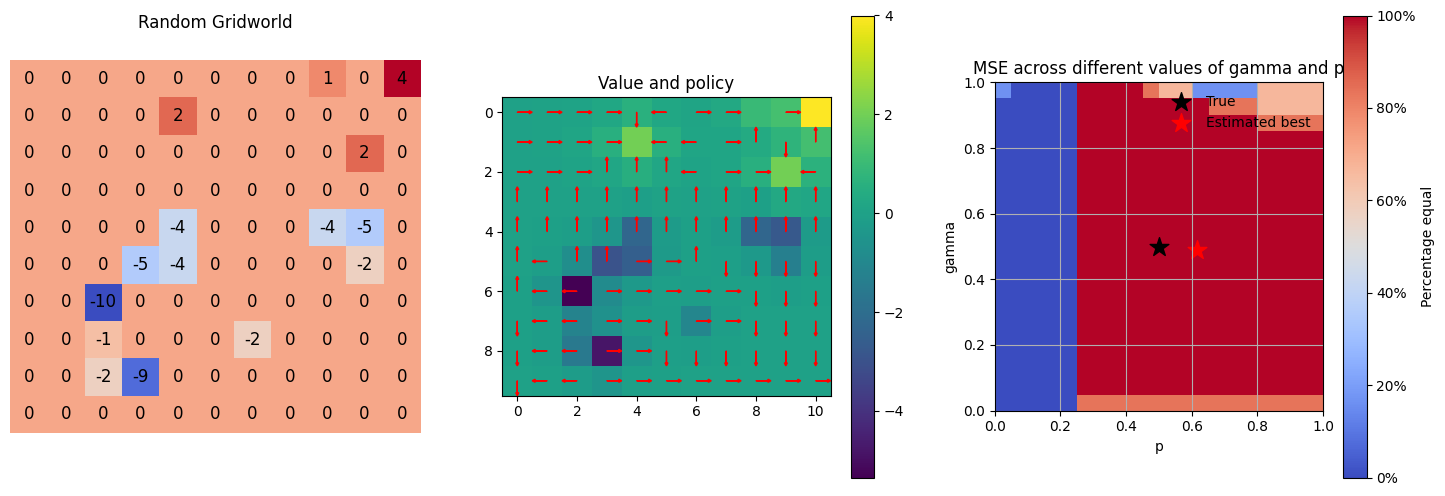

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.  , 0.  , 0.  , 0.  , 0.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1. 

In [53]:
solve_random_world(true_params, seed=69)

In [ ]:
# Run the function 5 times with different seeds to see different worlds
policy_match_list = []

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:14<00:00, 28.44it/s] 


Mean Best gamma: 0.25499999999999995, Mean Best p: 0.4871052631578947


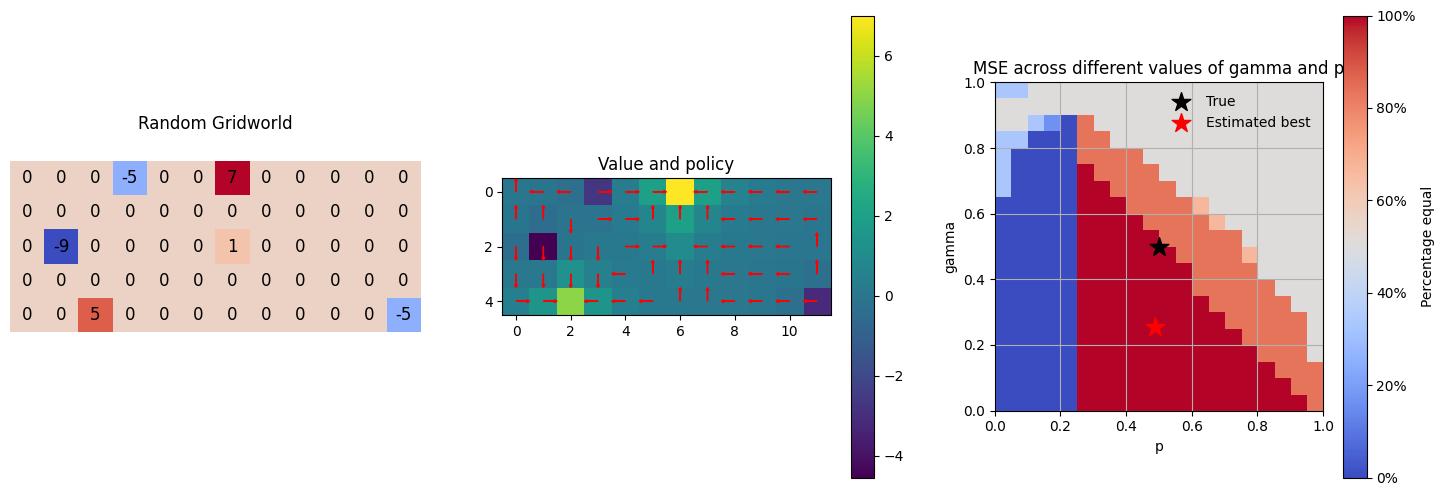

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:23<00:00, 16.76it/s] 


Mean Best gamma: 0.3431034482758621, Mean Best p: 0.5969328493647912


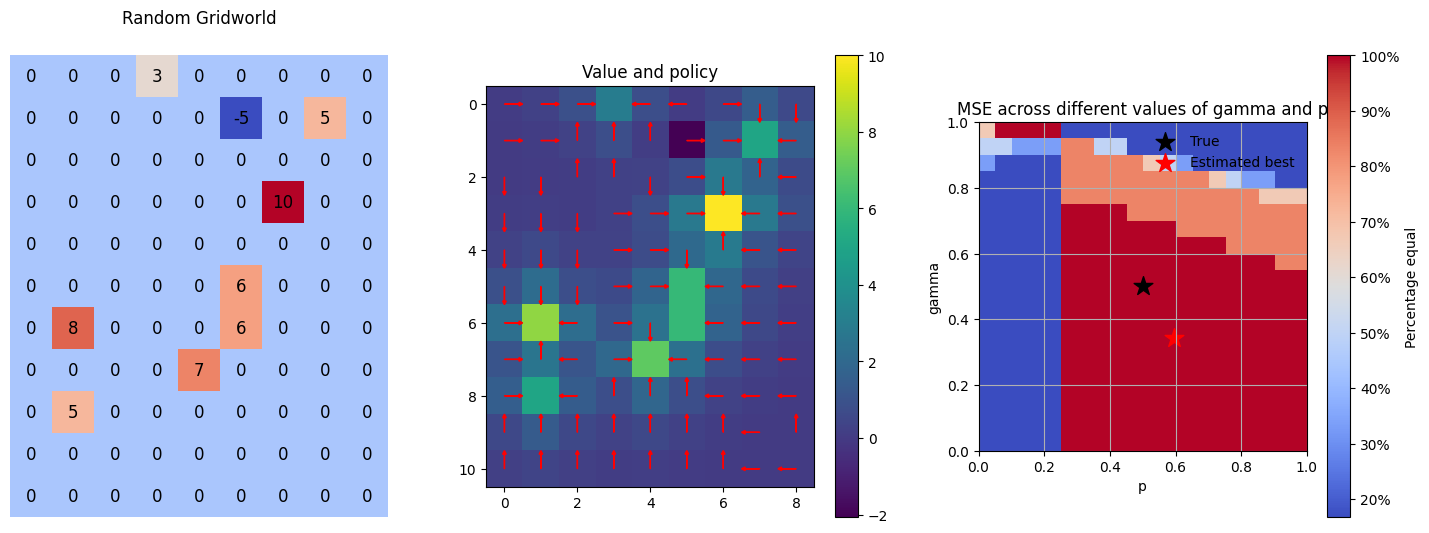

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:29<00:00, 13.42it/s] 


Mean Best gamma: 0.5888304093567253, Mean Best p: 0.68270955165692


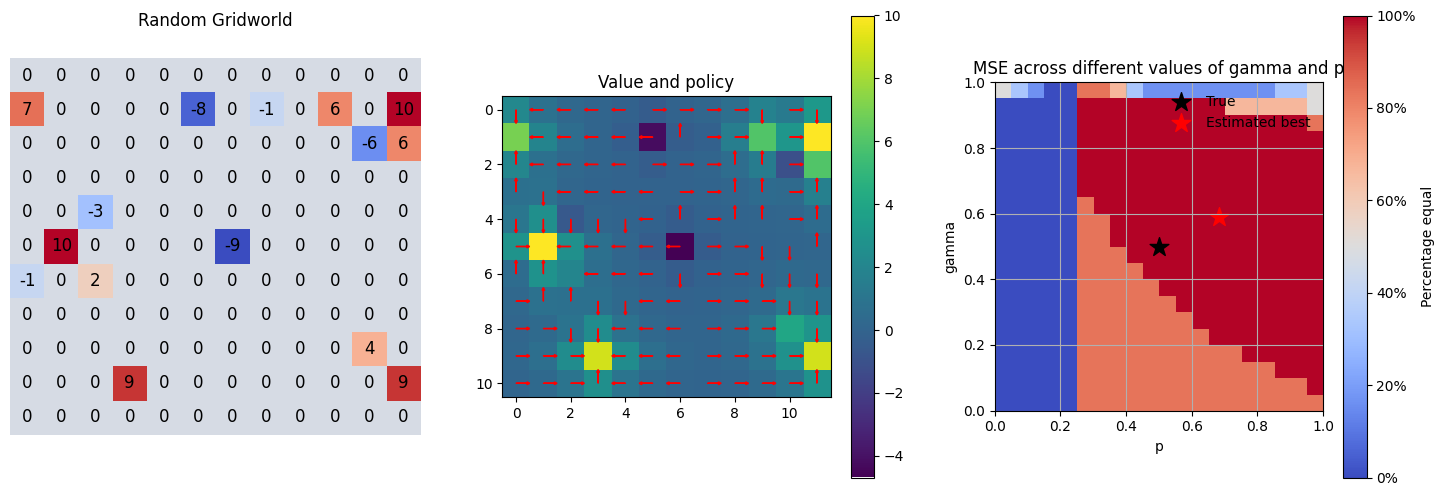

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:11<00:00, 35.07it/s] 


Mean Best gamma: 0.40416504223521765, Mean Best p: 0.6136647173489279


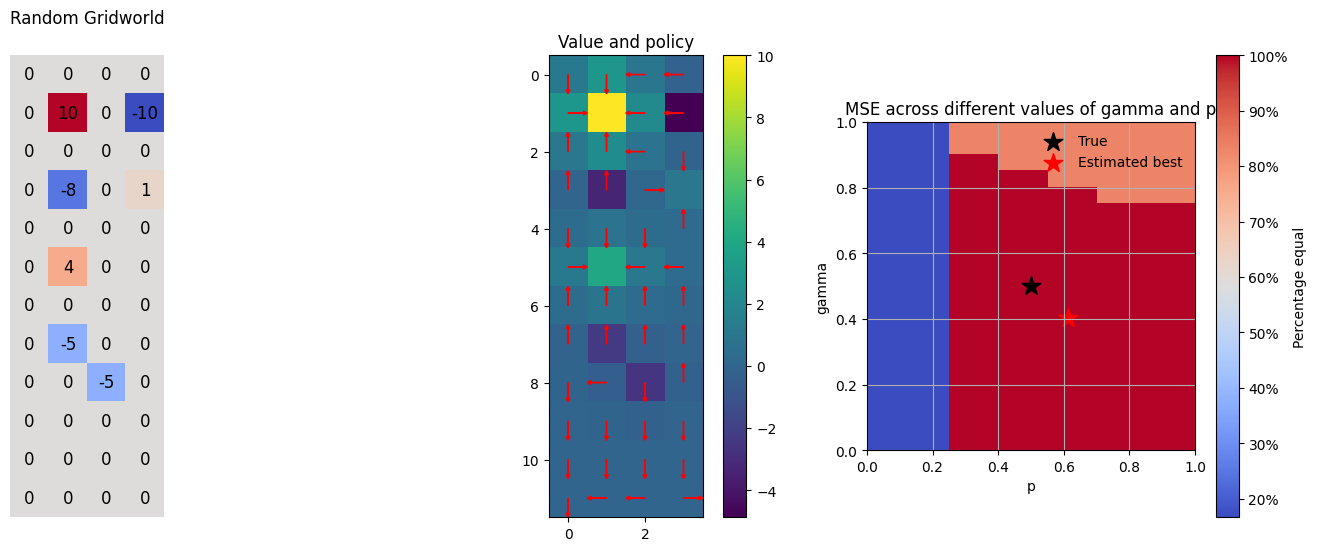

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:10<00:00, 39.18it/s]  


Mean Best gamma: 0.7039712918660288, Mean Best p: 0.4889473684210526


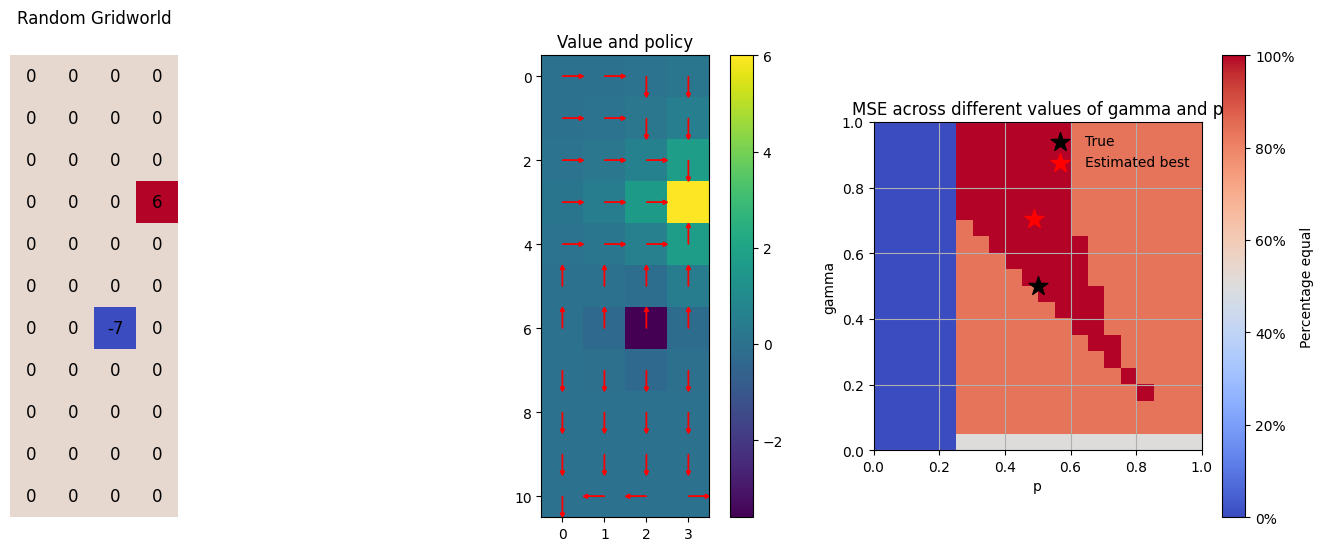

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:04<00:00, 82.42it/s] 


Mean Best gamma: 0.4999999999999999, Mean Best p: 0.6289473684210526


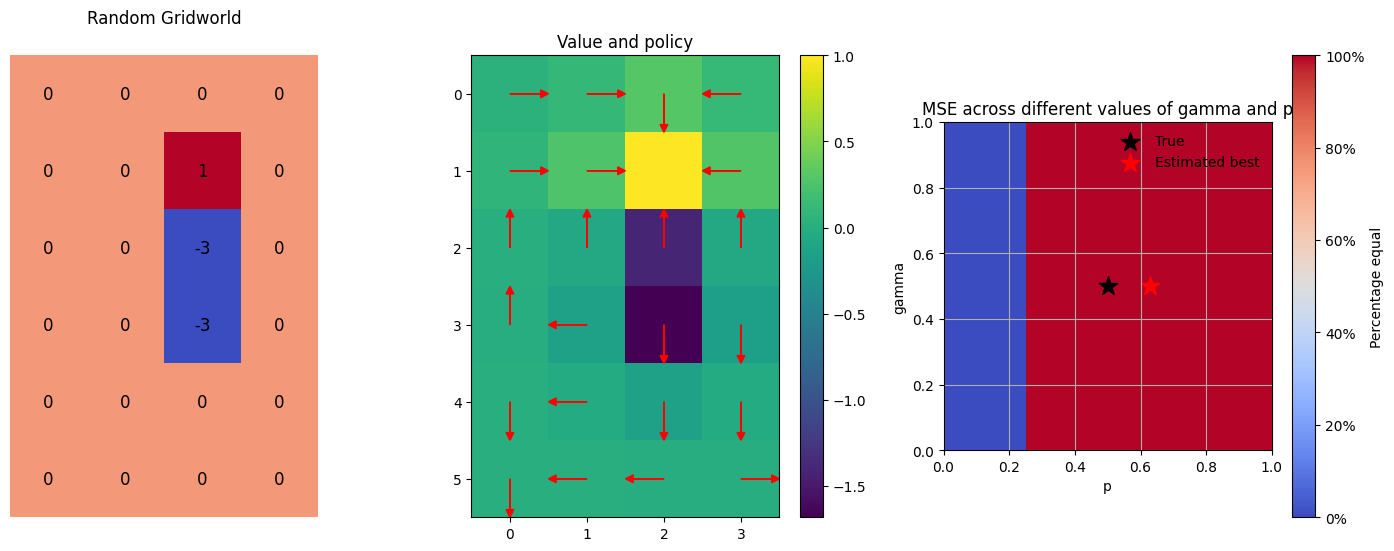

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:11<00:00, 34.68it/s] 


Mean Best gamma: 0.34848684210526315, Mean Best p: 0.6257236842105263


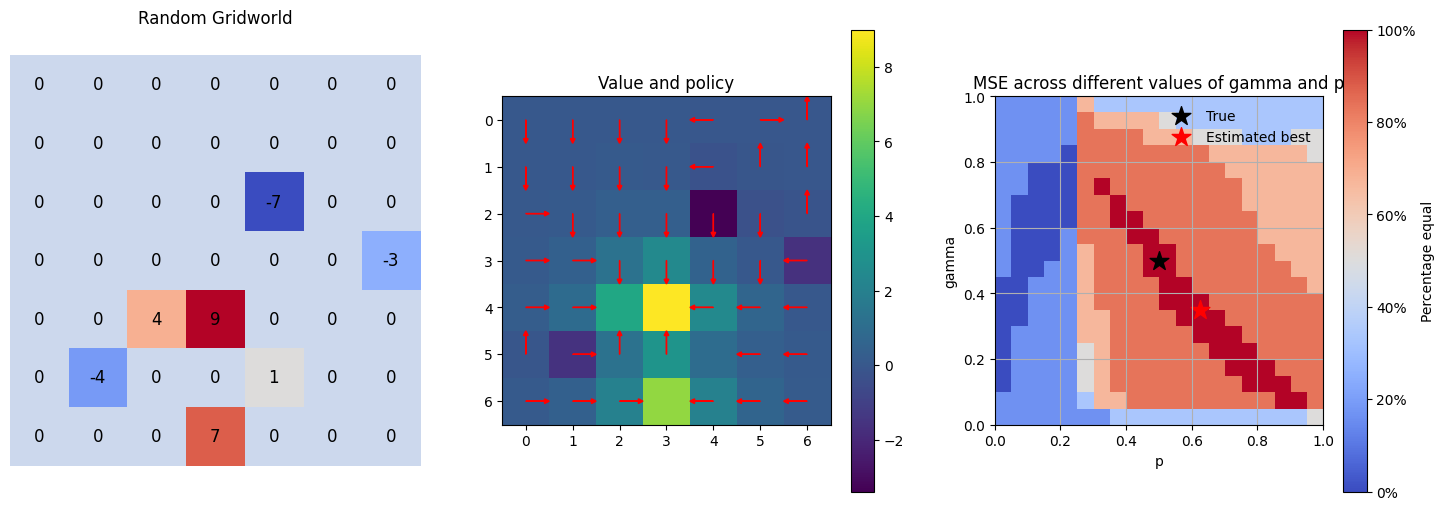

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:05<00:00, 71.97it/s] 


Mean Best gamma: 0.44757549611734254, Mean Best p: 0.6141501294219155


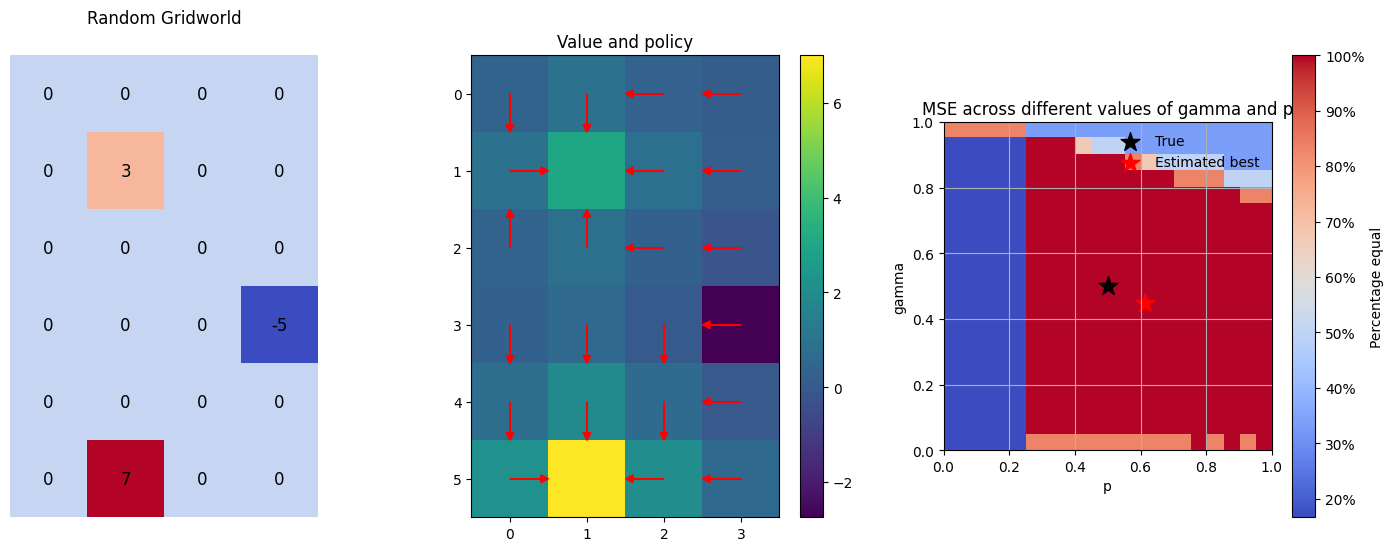

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:06<00:00, 64.86it/s]  


Mean Best gamma: 0.4226315789473684, Mean Best p: 0.6479072186394841


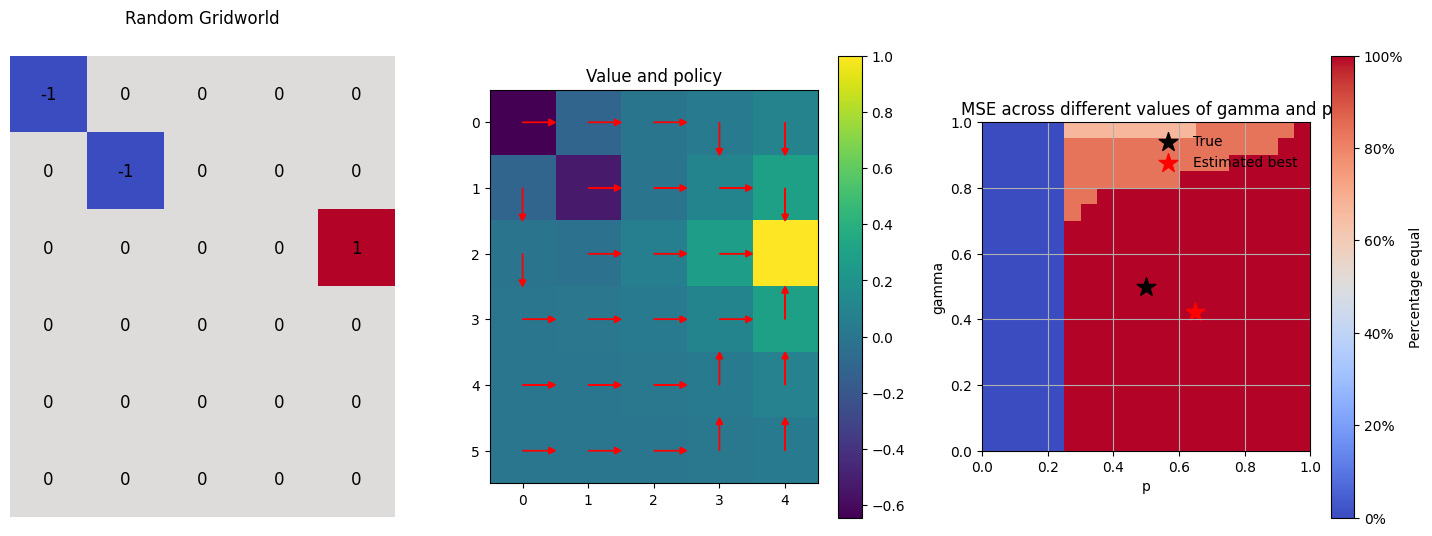

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:11<00:00, 34.53it/s] 


Mean Best gamma: 0.47293921423276497, Mean Best p: 0.6233172720533728


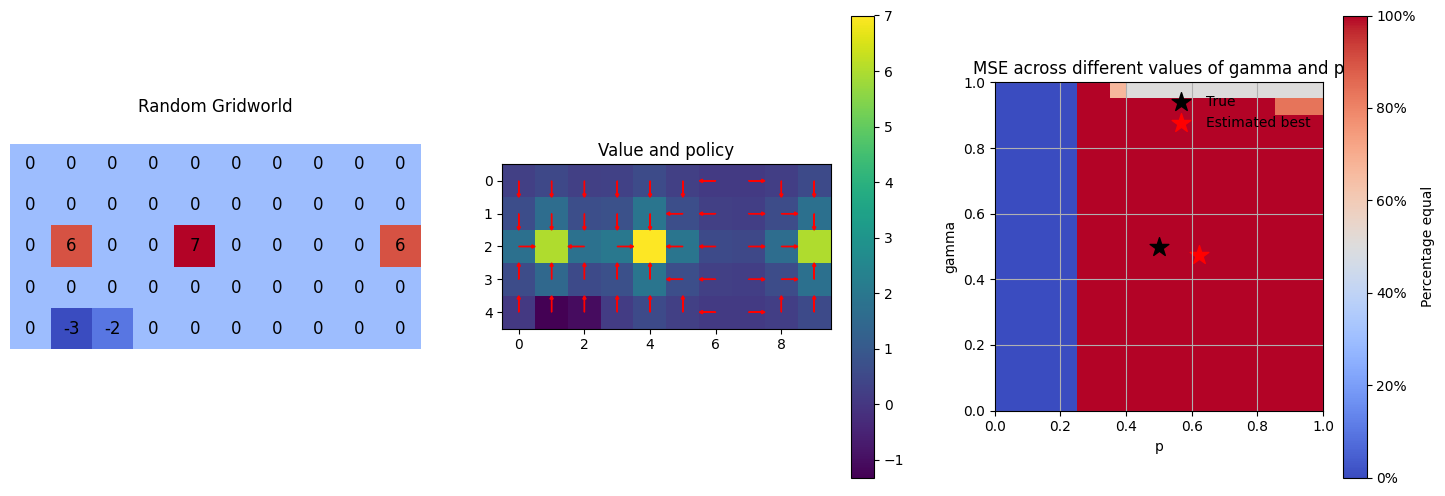

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:14<00:00, 27.72it/s] 


Mean Best gamma: 0.6756140350877192, Mean Best p: 0.4152631578947369


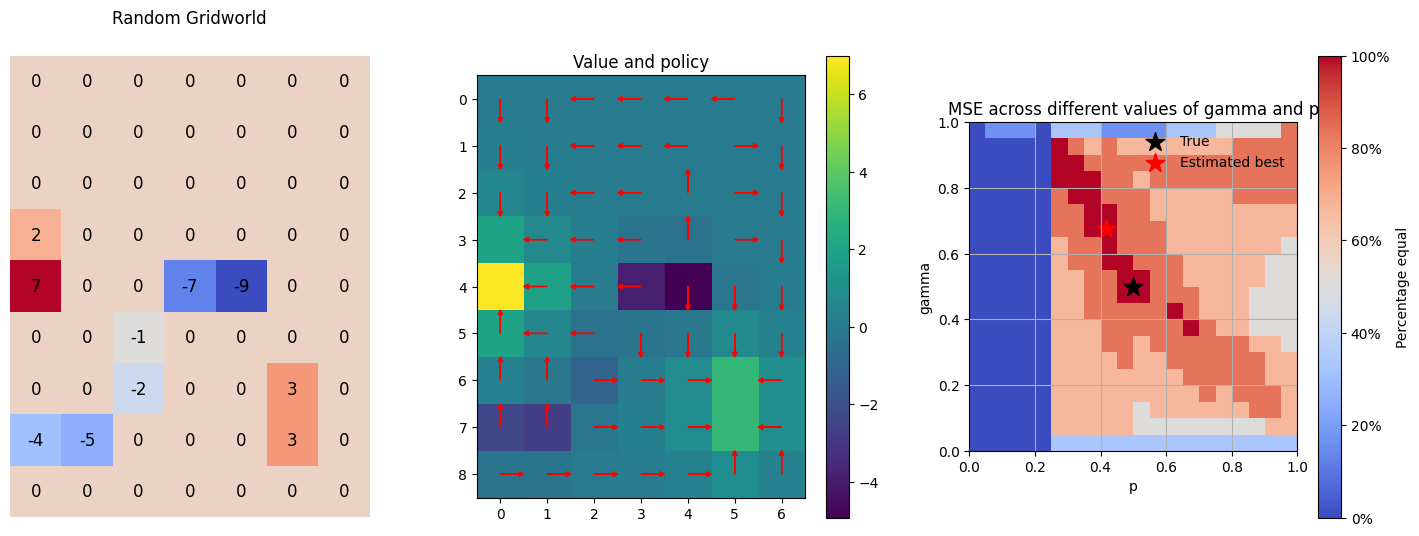

gamma=0.99, p=0.99: 100%|██████████| 400/400 [00:23<00:00, 16.88it/s] 


Mean Best gamma: 0.27402649981597355, Mean Best p: 0.5351674641148325


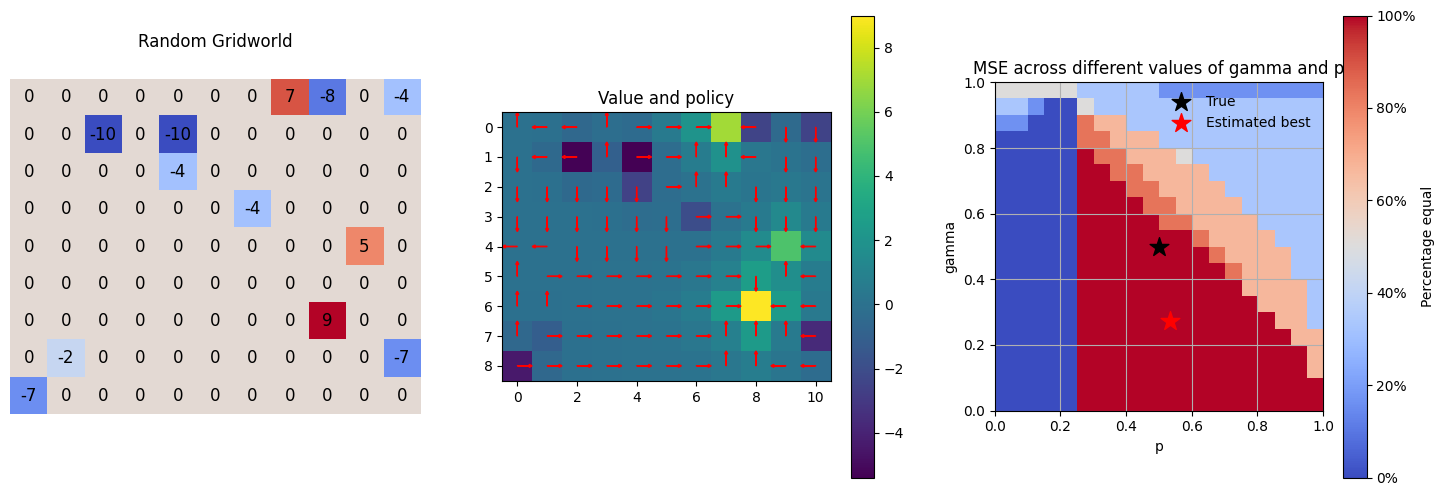

In [61]:
seed_offset = 420
for i in range(12):
    policy_match_list.append(solve_random_world(true_params, seed=i + seed_offset))

## How accurate and how quickly if we combine the results from multiple random worlds?


In [67]:
import random

Using seed: 223


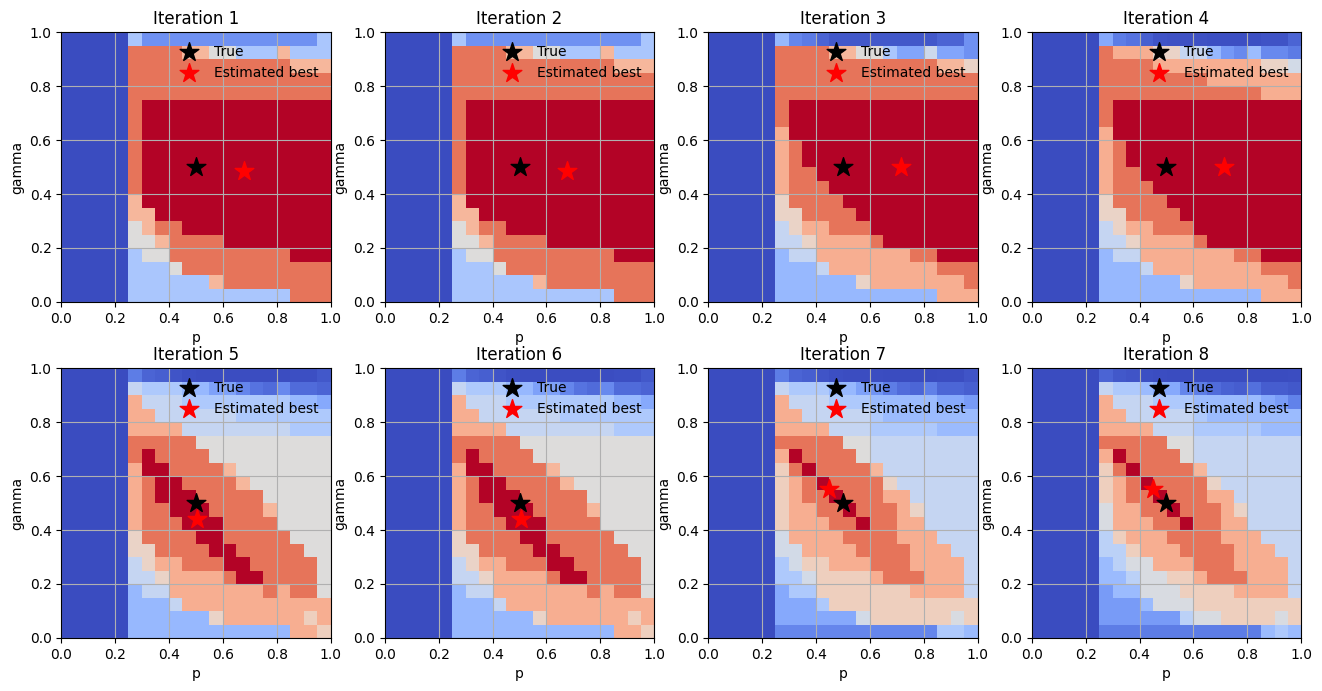

In [71]:
# Create a random seed
random_seed = random.randint(0, 1_000)

print(f"Using seed: {random_seed}")

# Set the random seed
random.seed(random_seed)
policy_match_subset = random.sample(policy_match_list, 8)

new_policy_matches = np.ones_like(policy_match_subset[0])

param_grid = list(product(gamma_values, p_values))

ncols, nrows = len(policy_match_subset) // 2, 2
# ncols, nrows = 3, 1


fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
axs = axs.flatten()


for i, (policy_matches, ax) in enumerate(zip(policy_match_subset, axs)):
    new_policy_matches *= policy_matches
    # Get indices of all minimum MSE values
    max_mse_indices = np.where(new_policy_matches == 1)[0]

    # Extract corresponding gamma and p values
    best_params = [param_grid[idx] for idx in max_mse_indices]
    est_params = get_param_estimate(best_params)

    plot_param_estimate(
        gamma_values,
        p_values,
        new_policy_matches,
        true_params=true_params,
        est_params=est_params,
        title=f"Iteration {i+1}",
        ax=ax,
    )

    # Remove the colorbar from all but the last plot
    ax.get_images()[0].colorbar.remove()

## Now, do we have to constrain ourselves to only view a sample of trajectories?

If so, how many trajectories can we observe, and how do we decide what starting states to use in each trajectory?

Also, what are we using as our matching metric? Estimated policy? Estimated value function? Estimated Q function? Occupancy measure?
